In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=43e88e73609282cf79ba76369ec1b4f4f21cff0dd421382cad5c33838892aa72
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import seaborn as sns
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from xgboost import XGBClassifier



from xgboost.sklearn import XGBClassifier as GBC
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler #(i added, used in cell )
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from scipy.stats import spearmanr


from xgboost.sklearn import XGBClassifier

import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
from __future__ import print_function

## from xgboost import XGBClassifier
import lime
import lime.lime_tabular

In [3]:
#Data Preprocessing - Checking for missing values

# Load your data
data = pd.read_csv('dataset-long-method.csv')

# Check for missing values
print(data.isnull().sum())
#no missing value found

dataset                                0
project                                0
package                                0
complextype                            0
method                                 0
                                      ..
number_protected_visibility_methods    0
number_public_visibility_methods       0
number_standard_design_methods         0
number_static_methods                  0
visibility_type                        0
Length: 90, dtype: int64


In [4]:
#One hot encoding

# Specify the columns to be one-hot encoded
categorical_columns = ['dataset', 'project', 'package', 'complextype', 'method', 'visibility_type']

# Apply one-hot encoding only to the specified categorical columns
encoded_data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Save the encoded DataFrame to a new CSV file
encoded_data.to_csv("encodeddataset-long-method.csv", index=False)

print("One-hot encoded data saved to 'encodeddataset-long-method.csv'")

One-hot encoded data saved to 'encodeddataset-long-method.csv'


In [5]:
import pandas as pd

# Assuming your dataset is in a CSV file and the severity column is named 'severity'
df = pd.read_csv('dataset-long-method.csv')

# Count the instances of each severity value
severity_counts = df['severity'].value_counts()

# Print the counts of each severity
print(severity_counts)

severity
1    280
3     95
4     34
2     11
Name: count, dtype: int64


<ipython-input-24-8d9ee16f84da>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="severity", palette="viridis")


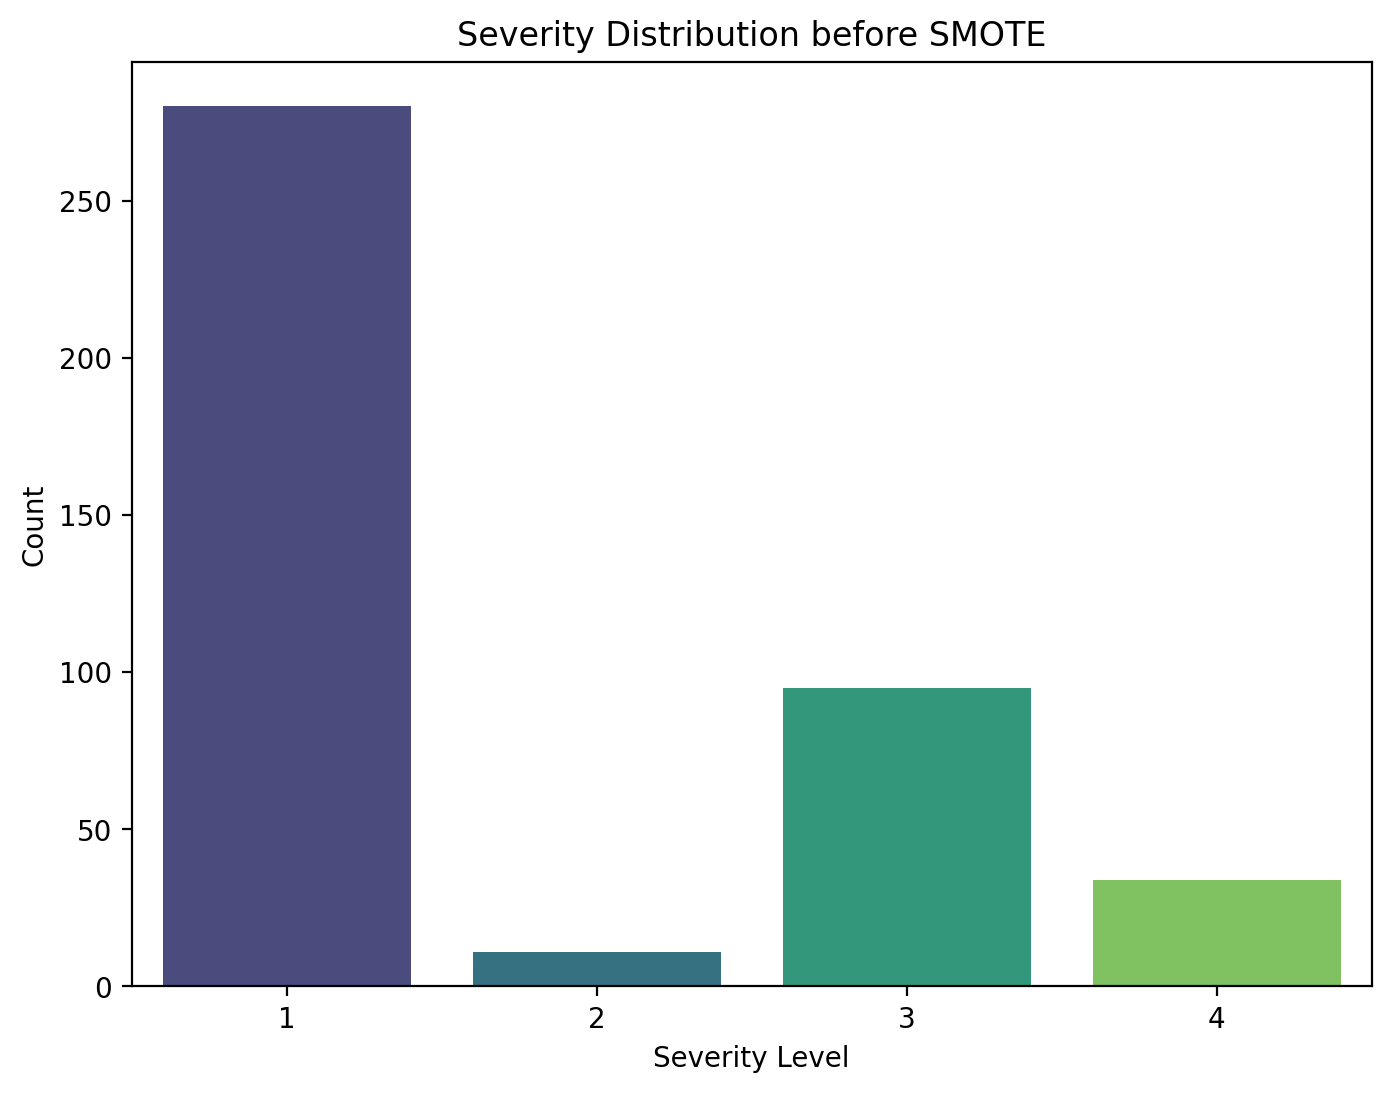

In [24]:
# Plot the new severity distribution before SMOTE
df = pd.read_csv('dataset-long-method.csv')
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="severity", palette="viridis")
plt.title("Severity Distribution before SMOTE")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.show()

In [6]:
import pandas as pd

# Assuming your dataset is in a CSV file and the severity column is named 'severity'
df = pd.read_csv('encodeddataset-long-method.csv')

# Count the instances of each severity value
severity_counts = df['severity'].value_counts()

# Print the counts of each severity
print(severity_counts)

severity
1    280
3     95
4     34
2     11
Name: count, dtype: int64


In [7]:
#Applying SMOTE to balance data

import pandas as pd
from imblearn.over_sampling import SMOTE

encoded_data = pd.read_csv("encodeddataset-long-method.csv")

# Separate features and target from encoded data
X = encoded_data.drop("severity", axis=1)
y = encoded_data["severity"]

# Identify columns with object (string) dtype
object_columns = X.select_dtypes(include=['object']).columns

# Convert object columns to numerical using Label Encoding
for col in object_columns:
    X[col] = pd.factorize(X[col])[0]  # Convert values to numerical using pd.factorize for compatibility with SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine resampled data into a DataFrame to verify
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name="severity")], axis=1)

# Save the resampled data
df_resampled.to_csv("encodeddataset-long-method.csv", index=False)

<ipython-input-8-47e2e9ed74c0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_resampled, x="severity", palette="viridis")


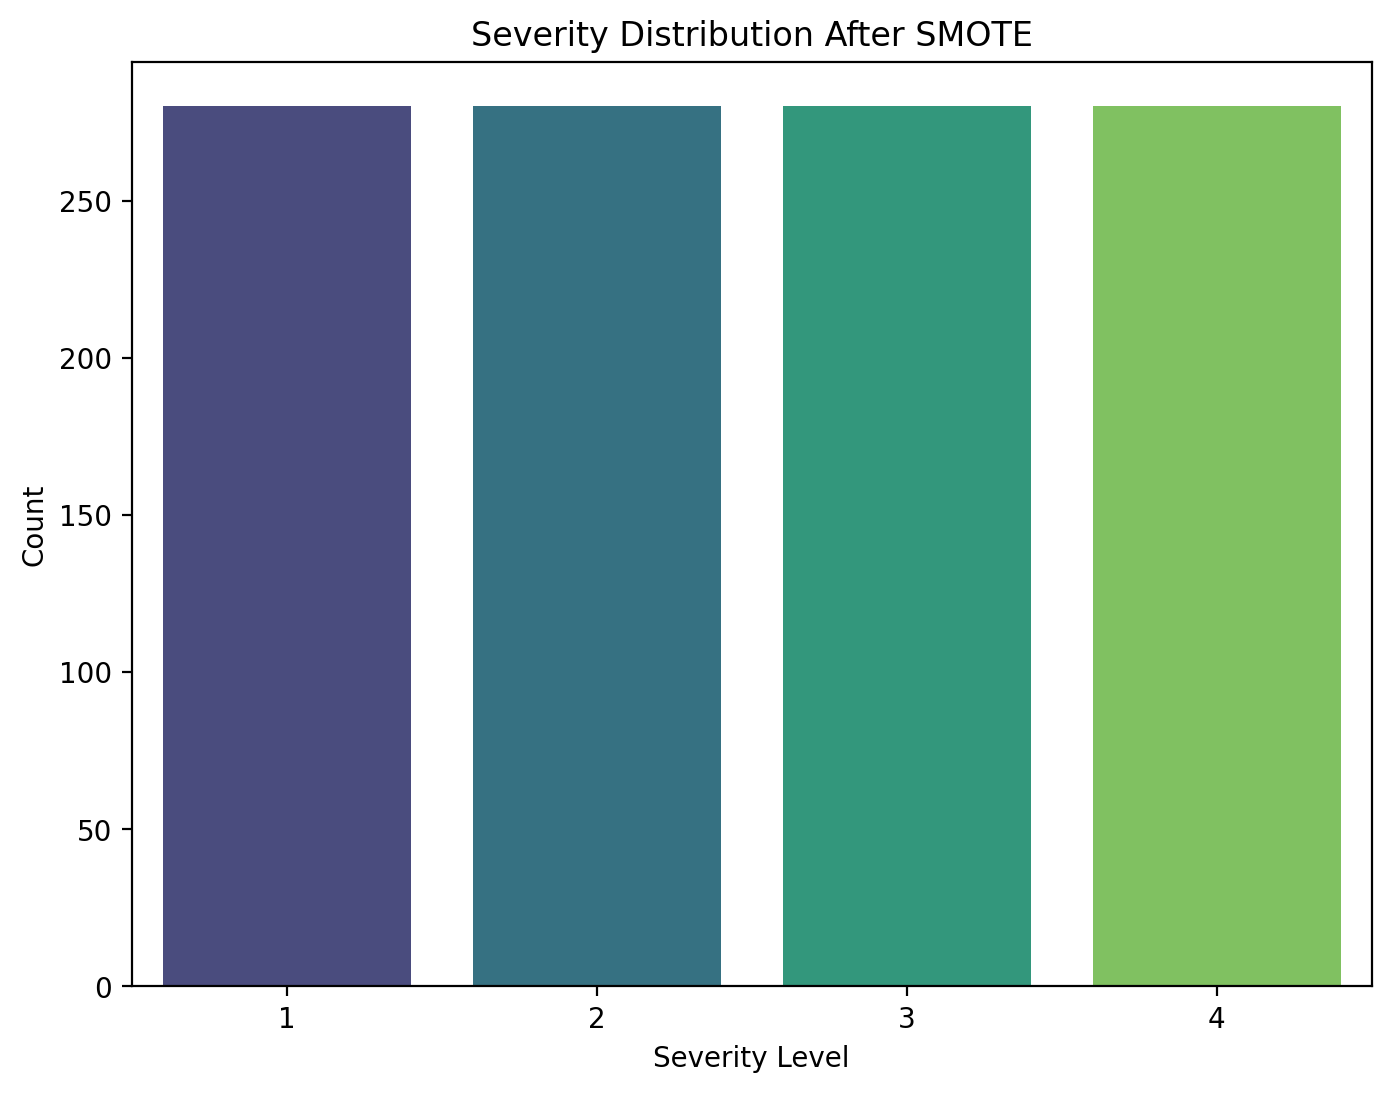

In [8]:
# Plot the new severity distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(data=df_resampled, x="severity", palette="viridis")
plt.title("Severity Distribution After SMOTE")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

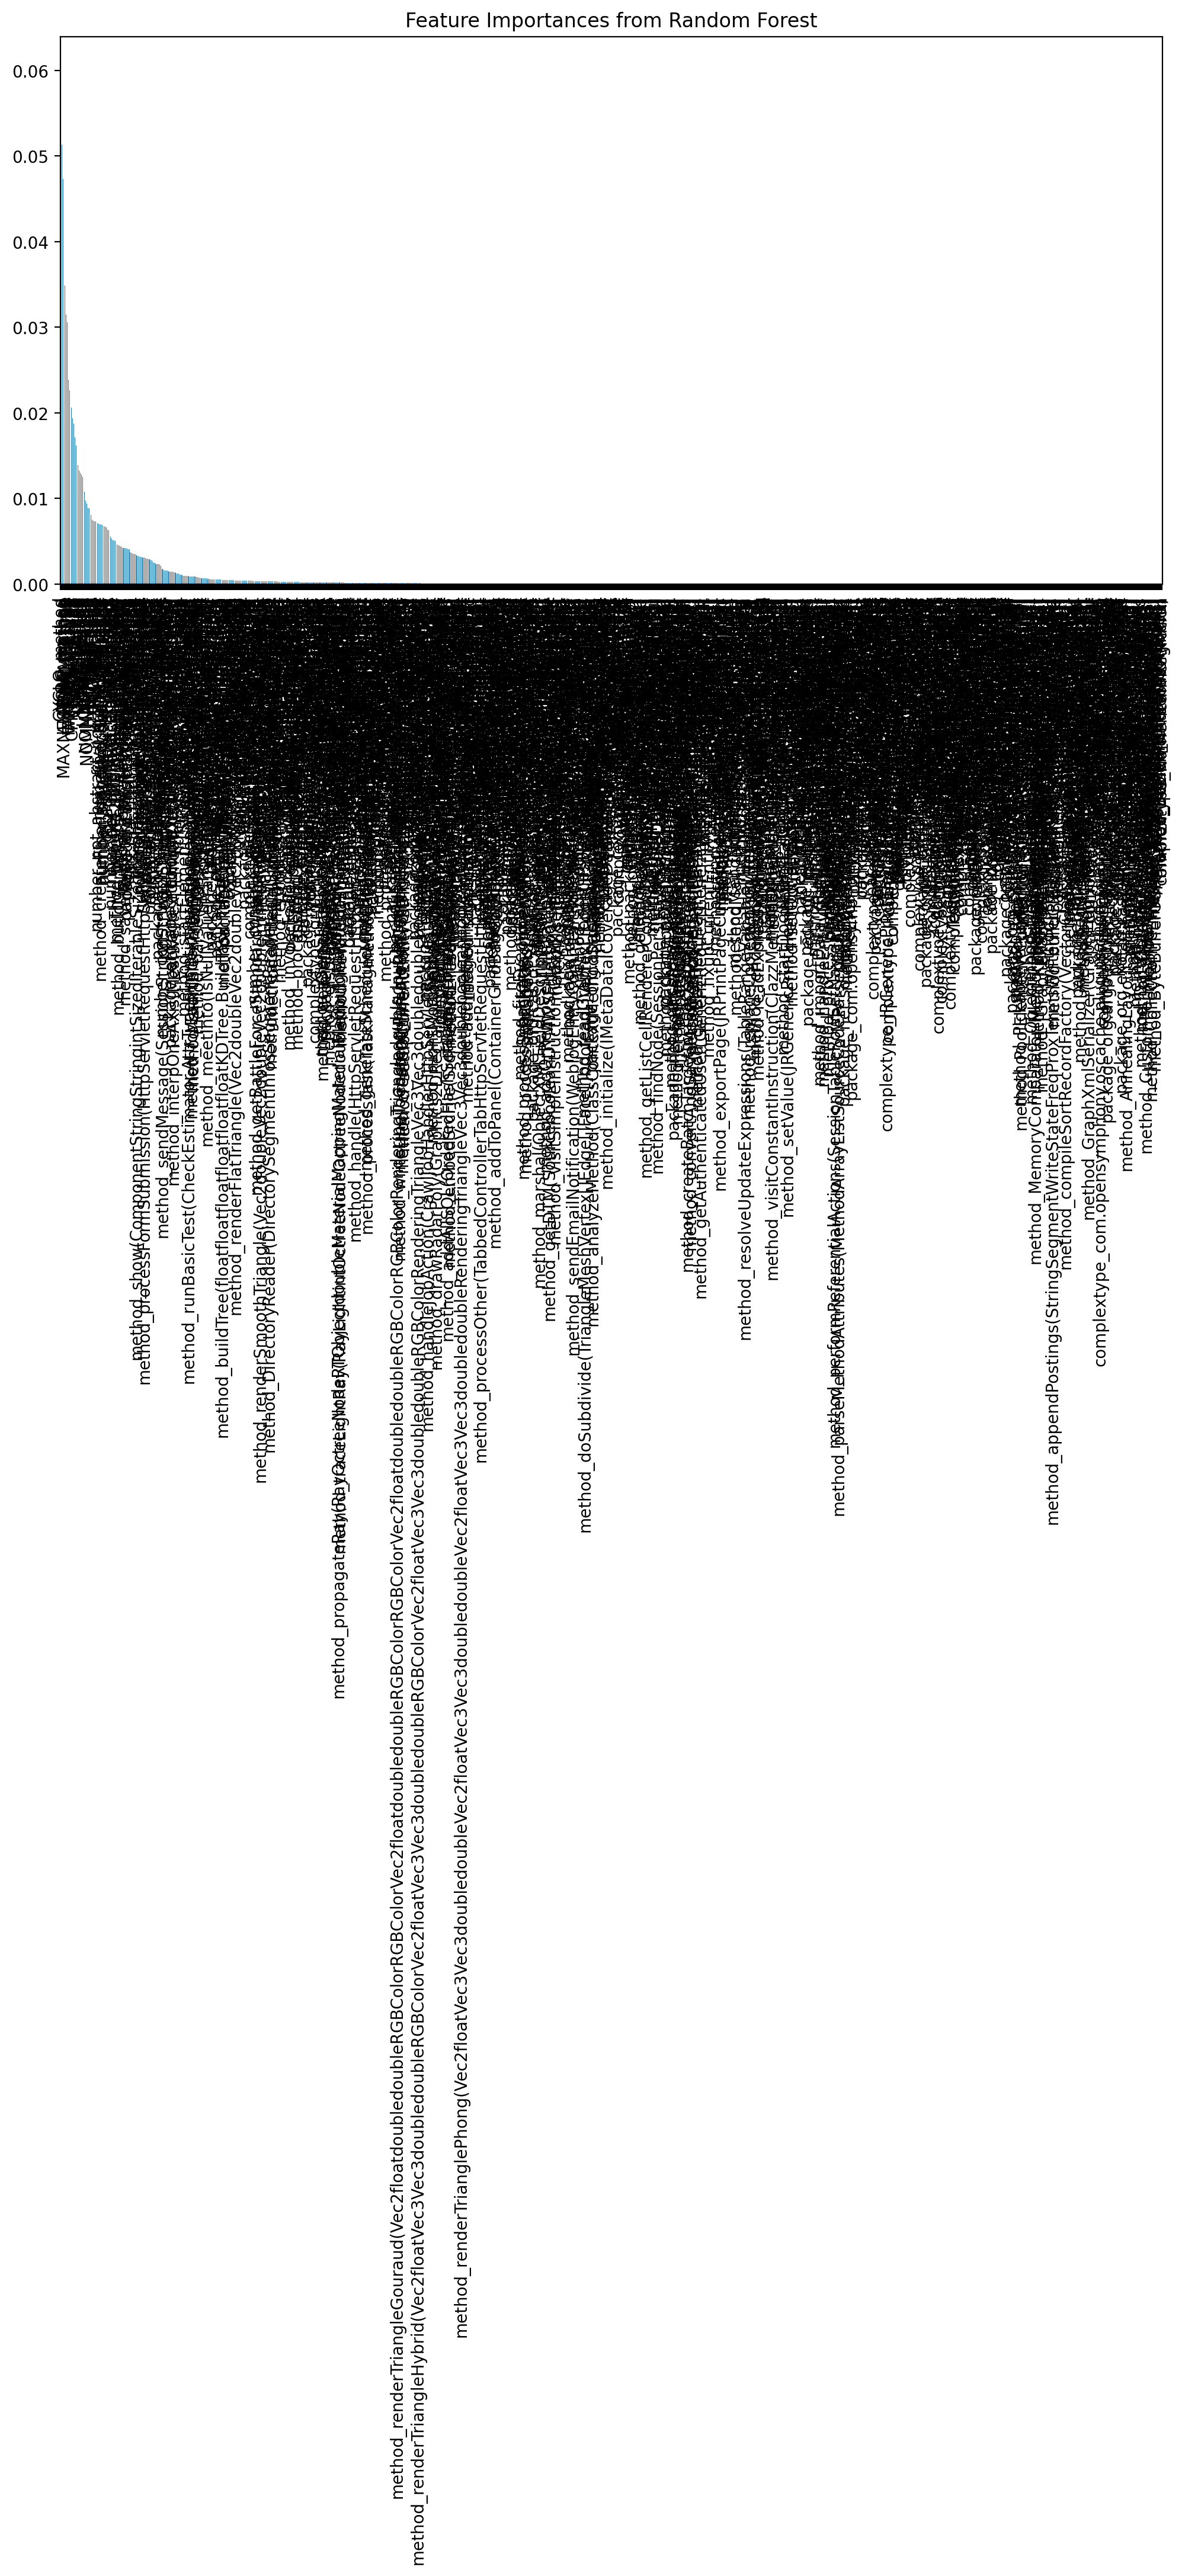

In [10]:
#Feature Engineering and Selection - For Random Forest, you can get feature importance scores directly
#part1
# Fit Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title="Feature Importances from Random Forest")
plt.show()


              Feature  Importance
7        CYCLO_method    0.079719
6          LOC_method    0.063942
9         NOLV_method    0.063269
5   MAXNESTING_method    0.059854
11        NOAV_method    0.047880
14      CFNAMM_method    0.045518
17        CINT_method    0.044279
13      FANOUT_method    0.028527
22           AMW_type    0.026008
55           WMC_type    0.023562


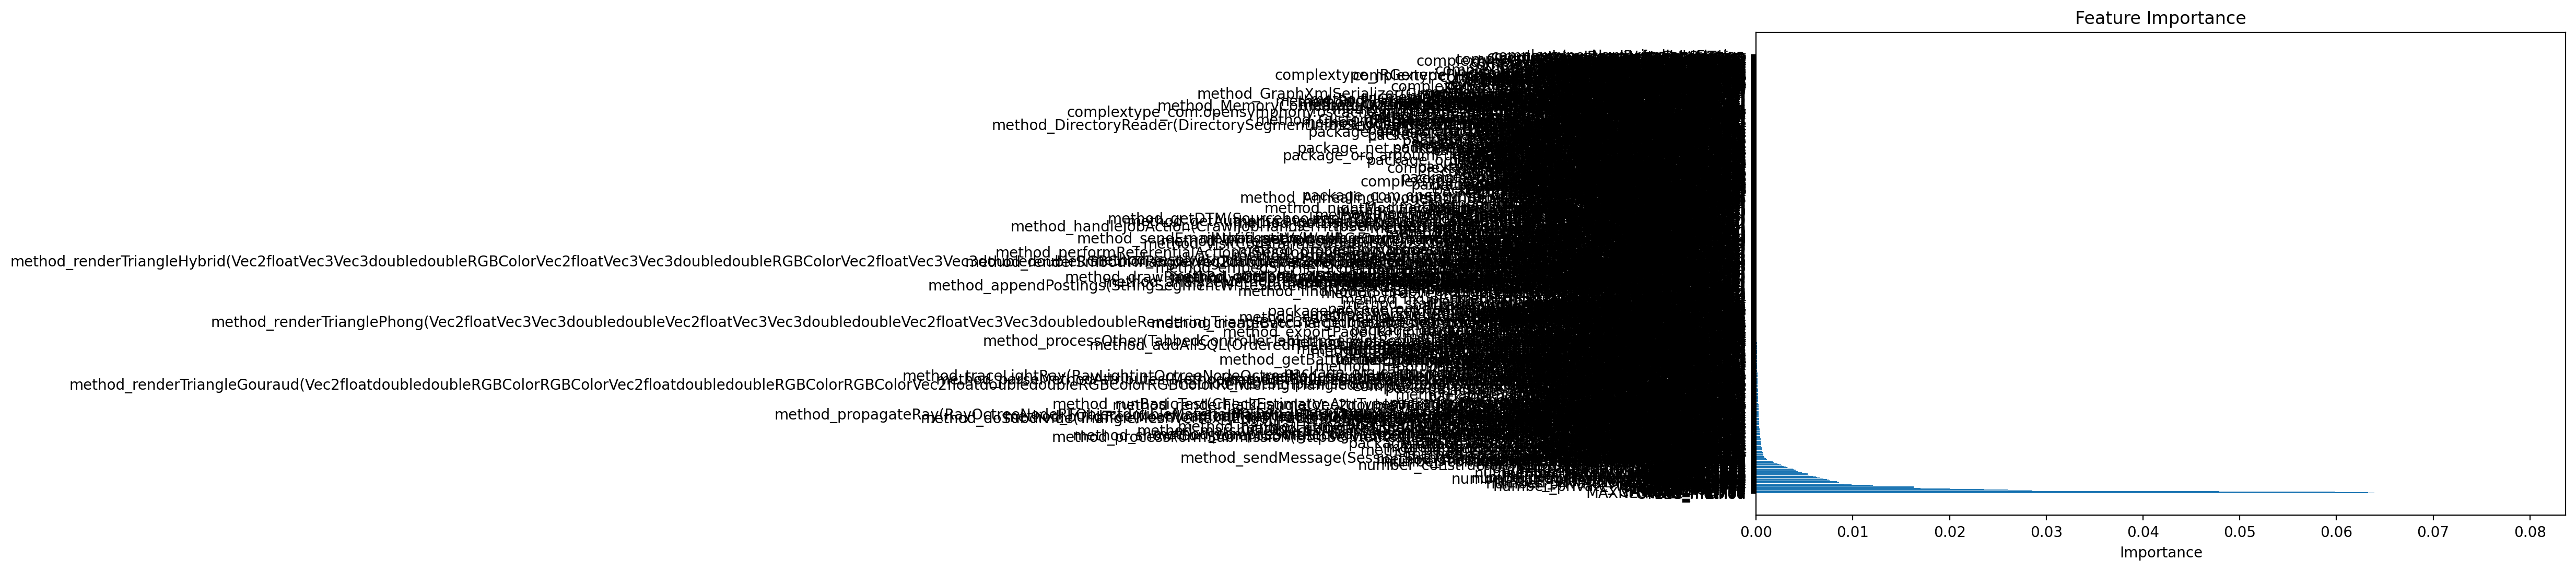

In [25]:
df = pd.read_csv("encodeddataset-long-method.csv")
# Initialize and fit the RandomForest model
model = RandomForestClassifier()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Get the top 10 most important features
top_10_features = importance_df.head(10)

# Print the top 10 features
print(top_10_features)

# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [11]:
#Dimensionality Reduction with PCA
#part 2

from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [12]:
#Scaling for SVM
#part3

from sklearn.preprocessing import StandardScaler

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
#2. Hyperparameter Tuning
#Random Forest Tuning with GridSearchCV
#Using GridSearchCV to find the best hyperparameters for Random Forest

from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest: ", grid_search_rf.best_params_)


Best parameters for Random Forest:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [14]:
#Best Parameters for Naive Bayes
from sklearn.naive_bayes import GaussianNB

param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

grid_search_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(X_train, y_train)

print("Best parameters for Naive Bayes: ", grid_search_nb.best_params_)

Best parameters for Naive Bayes:  {'var_smoothing': 1e-09}


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Set up GridSearchCV for SVM
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_scaled, y_train)

print("Best parameters for SVM: ", grid_search_svm.best_params_)

Best parameters for SVM:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [16]:
#Experimenting with different Models
from sklearn.ensemble import StackingClassifier

# Define the base models
estimators = [
    ('rf', RandomForestClassifier(**grid_search_rf.best_params_)),
    ('svm', SVC(**grid_search_svm.best_params_)),
    ('nb', GaussianNB(**grid_search_nb.best_params_))
]

# Define Stacking Classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())
stacking_clf.fit(X_train, y_train)


StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('svm', SVC(C=10)), ('nb', GaussianNB())],
                   final_estimator=RandomForestClassifier())

In [17]:
#Cross Validation
from sklearn.model_selection import cross_val_score

# Cross-validate Random Forest
rf_scores = cross_val_score(RandomForestClassifier(**grid_search_rf.best_params_), X, y, cv=5, scoring='accuracy')
print("Random Forest cross-validated accuracy: ", rf_scores.mean())

# Cross-validate SVM
svm_scores = cross_val_score(SVC(**grid_search_svm.best_params_), X, y, cv=5, scoring='accuracy')
print("SVM cross-validated accuracy: ", svm_scores.mean())

# Cross-validate Naive Bayes
nb_scores = cross_val_score(GaussianNB(**grid_search_nb.best_params_), X, y, cv=5, scoring='accuracy')
print("Naive Bayes cross-validated accuracy: ", nb_scores.mean())

Random Forest cross-validated accuracy:  0.8833333333333334
SVM cross-validated accuracy:  0.638095238095238
Naive Bayes cross-validated accuracy:  0.7023809523809523


In [18]:
#
from sklearn.metrics import classification_report, confusion_matrix

# Random Forest Predictions and Evaluation
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# SVM Predictions and Evaluation
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test_scaled)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

# Naive Bayes Predictions and Evaluation
y_pred_nb = grid_search_nb.best_estimator_.predict(X_test)
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))


Random Forest Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.96      0.98        96
           2       1.00      1.00      1.00        85
           3       0.96      1.00      0.98        85
           4       1.00      1.00      1.00        70

    accuracy                           0.99       336
   macro avg       0.99      0.99      0.99       336
weighted avg       0.99      0.99      0.99       336

Confusion Matrix:
 [[92  0  4  0]
 [ 0 85  0  0]
 [ 0  0 85  0]
 [ 0  0  0 70]]
SVM Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.73      0.80        96
           2       0.87      1.00      0.93        85
           3       0.85      0.87      0.86        85
           4       0.97      1.00      0.99        70

    accuracy                           0.89       336
   macro avg       0.89      0.90      0.89       336
weighted avg       0.89      0.89      

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from scipy.stats import spearmanr
import numpy as np
import pandas as pd

# Initialize a dictionary to store results
results = {
    "Classifier": [],
    "Spearman Correlation": [],
    "MAE": [],
    "RMSE": [],
    "Accuracy": []
}

# Define the classifiers with optimized hyperparameters
classifiers = {
    "Random Forest": RandomForestClassifier(**grid_search_rf.best_params_),
    "SVM": SVC(**grid_search_svm.best_params_),
    "Naive Bayes": GaussianNB(**grid_search_nb.best_params_)
}

# Evaluate each classifier
for clf_name, clf in classifiers.items():
    # Fit the model
    clf.fit(X_train_scaled if clf_name == "SVM" else X_train, y_train)  # SVM requires scaled data

    # Make predictions
    y_pred = clf.predict(X_test_scaled if clf_name == "SVM" else X_test)

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_test, y_pred)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Append results
    results["Classifier"].append(clf_name)
    results["Spearman Correlation"].append(spearman_corr)
    results["MAE"].append(mae)
    results["RMSE"].append(rmse)
    results["Accuracy"].append(accuracy)

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

      Classifier  Spearman Correlation       MAE      RMSE  Accuracy
0  Random Forest              0.974152  0.029762  0.243975  0.985119
1            SVM              0.843987  0.187500  0.595119  0.889881
2    Naive Bayes              0.897958  0.229167  0.531731  0.791667


In [20]:
# Initialize results dictionary
custom_results = {
    "Classifier": [],
    "Spearman Correlation": [],
    "MSE": [],
    "RMAE": [],
    "Accuracy": []
}


# Define your custom classifiers, making sure to import or define them first
custom_classifiers = {
    "R-B-JRIP": RandomForestClassifier(),  # Replace with actual R-B-JRIP model
    "R-RF": RandomForestClassifier(),      # Replace with actual R-RF model
    "R-B-RF": GaussianNB(),    # Replace with actual R-B-RF model
    "R-B-J48": RandomForestClassifier(),   # Replace with actual R-B-J48 model
    "R-JRIP": GaussianNB()     # Replace with actual R-JRIP model
}

# Evaluate each custom classifier
for clf_name, clf in custom_classifiers.items():
    # Fit the model
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_test, y_pred)

    # Calculate MSE and RMAE
    mse = mean_squared_error(y_test, y_pred)
    rmae = np.sqrt(mean_absolute_error(y_test, y_pred))

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Append results
    custom_results["Classifier"].append(clf_name)
    custom_results["Spearman Correlation"].append(spearman_corr)
    custom_results["MSE"].append(mse)
    custom_results["RMAE"].append(rmae)
    custom_results["Accuracy"].append(accuracy)

# Convert results into a DataFrame
custom_results_df = pd.DataFrame(custom_results)

# Display the results
print(custom_results_df)

  Classifier  Spearman Correlation       MSE      RMAE  Accuracy
0   R-B-JRIP              0.974152  0.059524  0.172516  0.985119
1       R-RF              0.974152  0.059524  0.172516  0.985119
2     R-B-RF              0.897958  0.282738  0.478714  0.791667
3    R-B-J48              0.968157  0.074405  0.196699  0.979167
4     R-JRIP              0.897958  0.282738  0.478714  0.791667


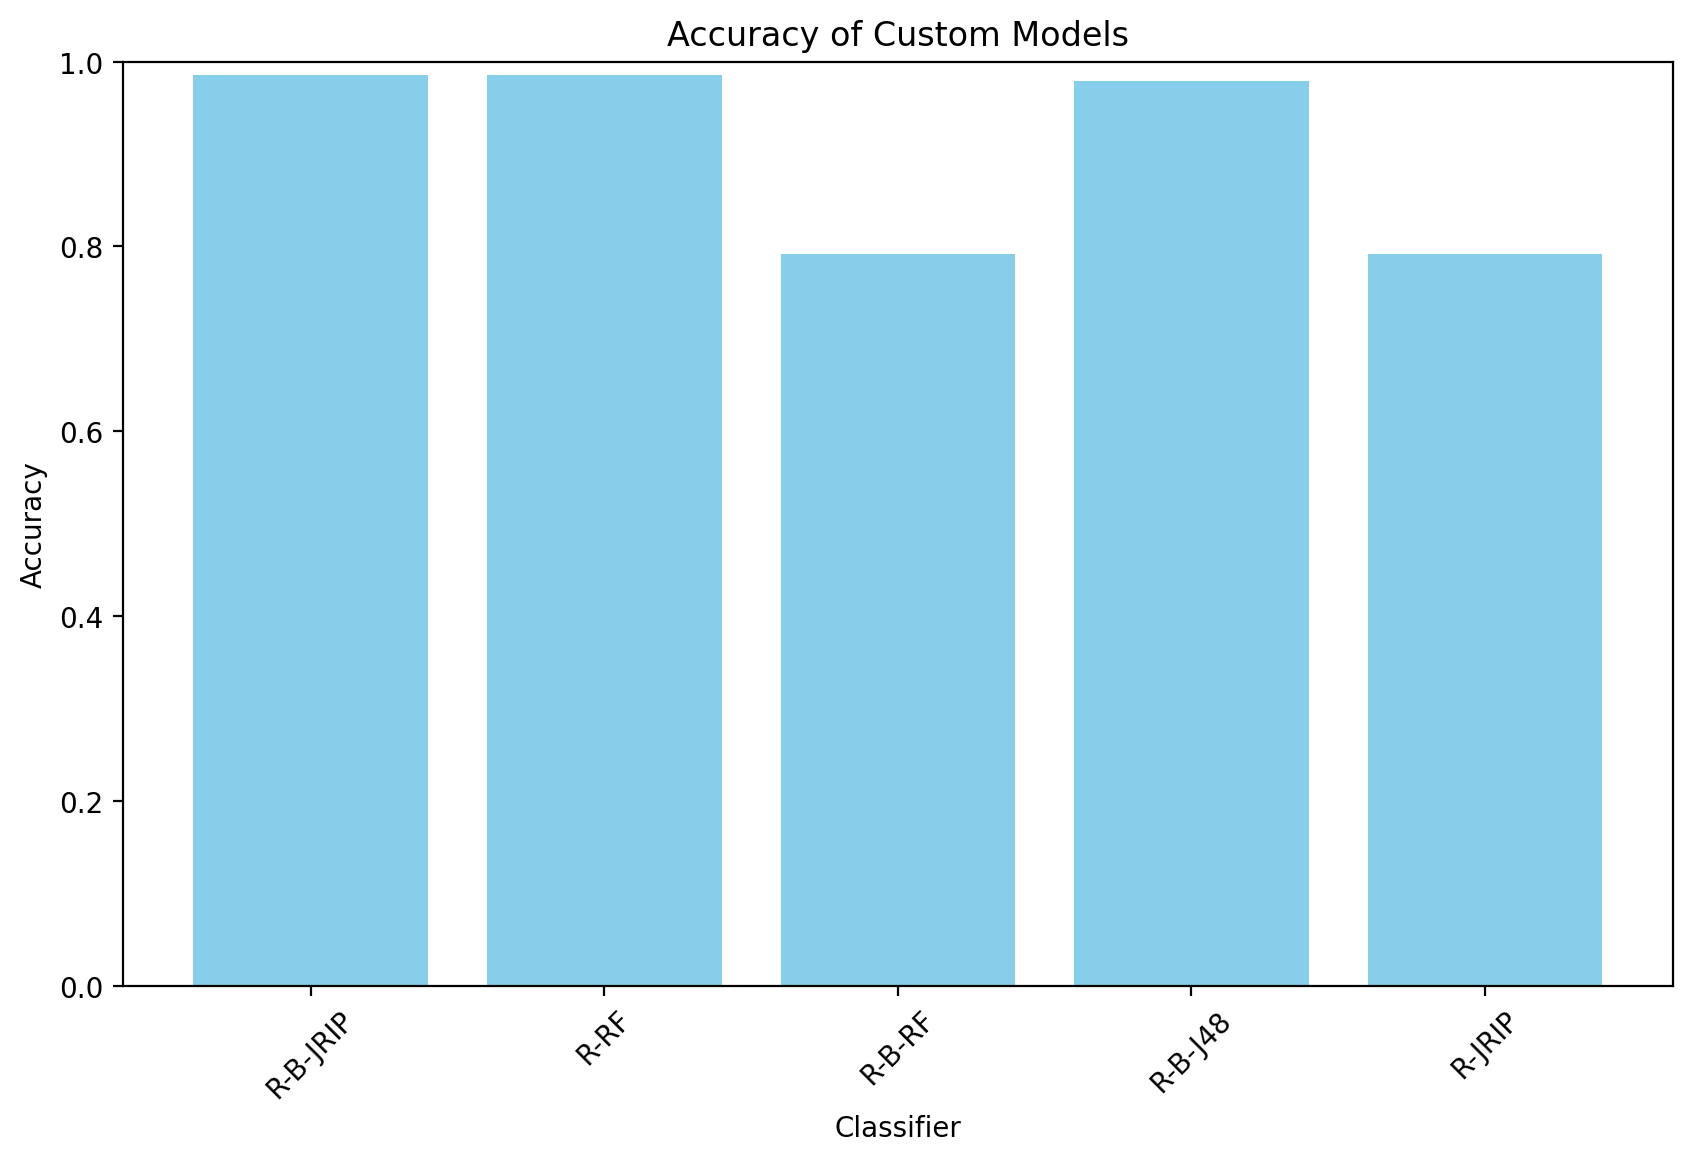

In [21]:

# Assuming 'custom_results_df' is the DataFrame with accuracy data
# Extract classifier names and accuracy scores
classifiers = custom_results_df["Classifier"]
accuracy_scores = custom_results_df["Accuracy"]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracy_scores, color='skyblue')
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Accuracy of Custom Models")
plt.xticks(rotation=45)  # Rotate classifier names for better readability
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Show the plot
plt.show()

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr, kendalltau

# Define Ordinal Classifiers
classifiers_ordinal = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
}

# Store results
ordinal_results = {
    "Classifier": [],
    "Spearman Correlation": [],
    "RMSE": [],
    "MAE": [],
    "Accuracy": []
}

# Evaluate each classifier
for clf_name, clf in classifiers_ordinal.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate metrics
    spearman_corr, _ = spearmanr(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Append results to dictionary
    ordinal_results["Classifier"].append(clf_name)
    ordinal_results["Spearman Correlation"].append(spearman_corr)
    ordinal_results["RMSE"].append(rmse)
    ordinal_results["MAE"].append(mae)
    ordinal_results["Accuracy"].append(accuracy)

# Convert to DataFrame
ordinal_results_df = pd.DataFrame(ordinal_results)
print(ordinal_results_df)


      Classifier  Spearman Correlation      RMSE       MAE  Accuracy
0  Random Forest              0.979291  0.218218  0.023810  0.988095
1            SVM              0.158680  1.334077  0.898810  0.455357
2    Naive Bayes              0.897958  0.531731  0.229167  0.791667


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr, kendalltau

# Define regression models
regressors = {
    "RF": RandomForestRegressor(),
    "SVM": SVR(),
    "Naive Bayes": GaussianNB(),  # Generally used for classification, but we'll use it as per your request
}

# Store results for regression
regression_results = {
    "Classifier": [],
    "Spearman Correlation": [],
    "Kendall Correlation": [],
    "MAE": [],
    "RMSE": [],
    "Accuracy": []
}

# Evaluate each regressor
for reg_name, reg in regressors.items():
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_test, y_pred)

    # Calculate Kendall correlation
    kendall_corr, _ = kendalltau(y_test, y_pred)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Accuracy calculation (within 5% margin for regression)
    accuracy = np.mean(np.abs((y_test - y_pred) / y_test) < 0.1)  # 5% tolerance

    # Append results to the dictionary
    regression_results["Classifier"].append(reg_name)
    regression_results["Spearman Correlation"].append(spearman_corr)
    regression_results["Kendall Correlation"].append(kendall_corr)
    regression_results["MAE"].append(mae)
    regression_results["RMSE"].append(rmse)
    regression_results["Accuracy"].append(accuracy)

# Convert the results into a DataFrame
regression_results_df = pd.DataFrame(regression_results)

# Display the results
print(regression_results_df)



    Classifier  Spearman Correlation  Kendall Correlation       MAE      RMSE  \
0           RF              0.971807             0.915113  0.051756  0.174435   
1          SVM              0.072389             0.050233  0.922824  1.136183   
2  Naive Bayes              0.897958             0.857951  0.229167  0.531731   

   Accuracy  
0  0.925595  
1  0.235119  
2  0.791667  
